# About Dataset:
    The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be subscribed or not.
### Aim
    To predict if the client will subscribe to a term deposit (variable y).

### Data Description
    A. Bank Client Data
        1. age: (numeric)
        2. job: type of job (categorical: "admin.", "unknown", "unemployed", "management", "housemaid", "entrepreneur", "student", "blue-collar","self-employed", "retired", "technician", "services") 
        3. marital: marital status (categorical: "married", "divorced", "single"; note: "divorced" means divorced or widowed)
        4. education: (categorical: "unknown", "secondary", "primary", "tertiary")
        5. default: has credit in default? (Binary: "yes", "no")
        6. balance: average yearly balance, in euros (numeric) 
        7. housing: has housing loan? (Binary: "yes", "no")
        8. loan: has personal loan? (Binary: "yes", "no")

    B. Variables related with the last contact of the current campaign:
        9. contact: contact communication type (categorical: "unknown", "telephone", "cellular") 
        10. day: last contact day of the month (numeric)
        11. month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
        12. duration: last contact duration, in seconds (numeric)

    C. other attributes:
        13. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
        14. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
        15. previous: number of contacts performed before this campaign and for this client (numeric)
        16. poutcome: outcome of the previous marketing campaign (categorical: "unknown", "other", "failure", "success")Output variable (desired target):
        17. y - has the client subscribed a term deposit? (Binary: "yes", "no")

    ** Target variable is y **

# Importing Necessary Libaries

In [1]:
import pandas as pd                 #library used for data processing(manipulation and analysis)
import numpy as np                  #library used for working with arrays, and linear algebra
import seaborn as sns               #library used for Data Visualization, built on top of matplotlib
import matplotlib.pyplot as plt     #library used for Data Visualization

from scipy.stats import skew        #To check the skewness of the Distribution

#For Model Building
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score,precision_score,recall_score,f1_score
from sklearn.preprocessing import StandardScaler,OrdinalEncoder,OneHotEncoder
from sklearn.compose import make_column_transformer

#Pipeline
from imblearn.pipeline import make_pipeline
from imblearn.combine import SMOTETomek  #Combination of Oversampling and Undersampling techniques
from sklearn import set_config  #To visualize Pipeline
set_config(display='diagram')

from warnings import filterwarnings #to suppress warnings
filterwarnings('ignore')

%matplotlib inline                  
#allows plots to be displayed directly in the notebook


# Reading the data

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
# Checking the shape of the dataset
print('Shape of training data: ', df_train.shape)
print('Shape of testing data: ', df_test.shape)

Shape of training data:  (33908, 17)
Shape of testing data:  (11303, 16)


In [4]:
df_train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,retired,married,secondary,no,166,no,yes,unknown,3,jul,211,1,-1,0,unknown,no
1,51,blue-collar,married,primary,no,2995,yes,no,unknown,11,jun,93,2,-1,0,unknown,no
2,50,management,married,tertiary,no,569,no,yes,cellular,18,aug,452,4,-1,0,unknown,no
3,27,admin.,married,secondary,no,73,yes,no,cellular,5,feb,140,1,-1,0,unknown,no
4,38,self-employed,divorced,tertiary,no,6447,no,no,cellular,12,jan,296,1,-1,0,unknown,no


In [5]:
# Data Summary
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33908 entries, 0 to 33907
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        33908 non-null  int64 
 1   job        33908 non-null  object
 2   marital    33908 non-null  object
 3   education  33908 non-null  object
 4   default    33908 non-null  object
 5   balance    33908 non-null  int64 
 6   housing    33908 non-null  object
 7   loan       33908 non-null  object
 8   contact    33908 non-null  object
 9   day        33908 non-null  int64 
 10  month      33908 non-null  object
 11  duration   33908 non-null  int64 
 12  campaign   33908 non-null  int64 
 13  pdays      33908 non-null  int64 
 14  previous   33908 non-null  int64 
 15  poutcome   33908 non-null  object
 16  y          33908 non-null  object
dtypes: int64(7), object(10)
memory usage: 4.4+ MB


In [6]:
#Statistical Summary
df_train.describe()

,age,balance,day,duration,campaign,pdays,previous
count,33908.000000,33908.000000,33908.000000,33908.000000,33908.000000,33908.000000,33908.000000
mean,40.966763,1370.713136,15.803763,257.899227,2.752920,40.168515,0.581987
std,10.613701,3111.689069,8.314558,258.607105,3.068299,99.892114,2.412482
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,74.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,450.000000,16.000000,179.000000,2.000000,-1.000000,0.000000
75%,48.000000,1430.000000,21.000000,318.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [7]:
# Missing value Analysis
a = df_train.isnull().sum()
b = df_train.isnull().sum()/df_train.shape[0]

c = df_test.isnull().sum()
d = df_test.isnull().sum()/df_test.shape[0]

missing_data_train = pd.concat([a,b],axis=1,keys=['sum','percentage'])
missing_data_test = pd.concat([c,d],axis=1,keys=['sum','percentage'])

missing_data = pd.concat([missing_data_train,missing_data_test],axis=1,keys=['Training','Testing'])
missing_data

Training            Testing           
               sum percentage     sum percentage
age              0        0.0     0.0        0.0
job              0        0.0     0.0        0.0
marital          0        0.0     0.0        0.0
education        0        0.0     0.0        0.0
default          0        0.0     0.0        0.0
balance          0        0.0     0.0        0.0
housing          0        0.0     0.0        0.0
loan             0        0.0     0.0        0.0
contact          0        0.0     0.0        0.0
day              0        0.0     0.0        0.0
month            0        0.0     0.0        0.0
duration         0        0.0     0.0        0.0
campaign         0        0.0     0.0        0.0
pdays            0        0.0     0.0        0.0
previous         0        0.0     0.0        0.0
poutcome         0        0.0     0.0        0.0
y                0        0.0     NaN        NaN

#### Observation: 
* There are no Missing values in the dataset
* There are 33908 records in Training Data and 11303 records in Testing Data (Approx 33%)
* There are 10 categorical attributes and 7 numerical attributes

# Exploratory Data Analysis(EDA)

## Univariate Analysis

#### (1)Target Variable (y - has the client subscribed a term deposit? (Binary: "yes", "no"))
    Term Deposit : A Term Deposit is a type of investment where a fixed amount of money is deposited with a financial institution for a specified period of time, usually ranging from a few months to several years. During the term of the deposit, the funds cannot be withdrawn without incurring a penalty, and the interest rate on the deposit is fixed.Term deposits are generally considered low-risk investments because they offer a guaranteed return on investment and are typically insured by government deposit insurance programs.

In [8]:
a = df_train['y'].value_counts()
b = df_train['y'].value_counts()/df_train.shape[0]*100
target_data = pd.concat([a,b],axis=1,keys=['Count','Percentage'])
target_data

,Count,Percentage
no,29941,88.300696
yes,3967,11.699304


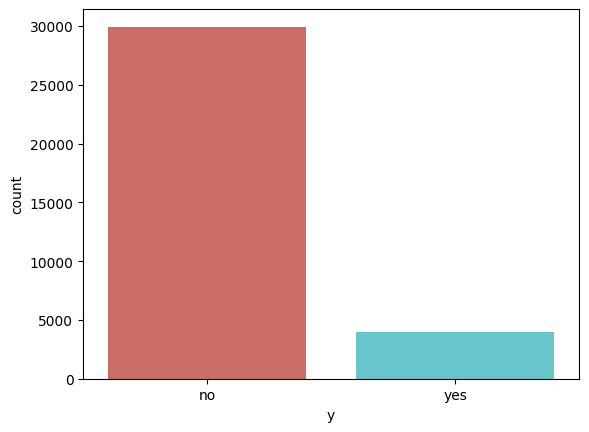

In [9]:
# Create a countplot 
sns.countplot(x='y', data=df_train,palette = 'hls')
plt.show()


##### Observation: 
* The data is imbalanced, with 88.3% of clients not subscribing to the term deposit and only 11.7% of clients subscribing to the term deposit.

#### (2)Age
    The "age" column is a numeric variable that describes the age of each client in the dataset. This variable is typically measured in years, and represents a continuous, quantitative variable.

In [10]:
#Descriptive Statistics of Age column
mean_age = df_train['age'].mean()
mode_age = df_train['age'].mode().iloc[0]
min_age = df_train['age'].min()
max_age = df_train['age'].max()

# Print the results
print('Mean age:', mean_age)
print('Mode age:', mode_age)
print('Minimum age:', min_age)
print('Maximum age:', max_age)


Mean age: 40.966763005780344
Mode age: 32
Minimum age: 18
Maximum age: 95


Distribution is Right Skewed by 0.6806101118840361


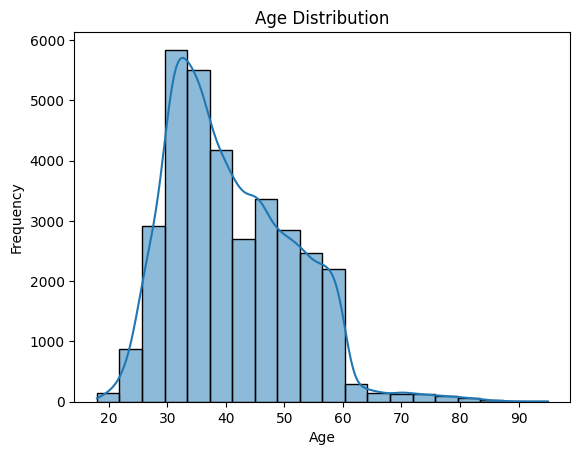

In [11]:
skewness = skew(df_train['age'])

if skewness > 0:
    print('Distribution is Right Skewed by', skewness)
elif skewness < 0:
    print('Distribution is Left Skewed by', skewness)
else:
    print('Distribution is Symmetric')

#histogram of the age column
sns.histplot(x='age',data=df_train,bins=20,kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

1st Quantile(Q1):  33.0
3st Quantile(Q3):  48.0
Interquartile range:  33.0
Innerfence:  10.5
Outerfence:  70.5


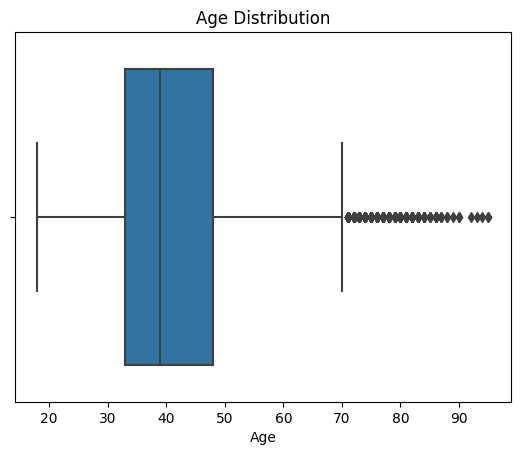

In [12]:
#Quantiles,Innerfence and Outerfence of the age column
q1 = df_train['age'].quantile(0.25)
q3 = df_train['age'].quantile(0.75)
iqr = q3-q1
innerfence = q1-(1.5*iqr)
outerfence = q3+(1.5*iqr)

print('1st Quantile(Q1): ',q1)
print('3st Quantile(Q3): ',q3)
print('Interquartile range: ',q1)
print('Innerfence: ',innerfence)
print('Outerfence: ',outerfence)

#Boxplot of the age column
sns.boxplot(x='age',data=df_train)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.show()

##### Observation: 
* Clients between the ages of 30 and 40 years are contacted more frequently than clients in other age groups
* Average age of clients is 40-41 years
* The most common age of client is 32 years
* Minimum age of client is 18 years
* Maximum age of client is 95 years
* Distribution of Age column is Right Skewed by 0.680

#### (3)Job
    The "job" column is a categorical variable that describes the type of job held by each client in the dataset. Each category represents a different type of job or employment status. This information may be useful in understanding the demographic and socioeconomic characteristics of the clients in the dataset, as well as in developing predictive models or analyzing patterns in client behavior.

In [13]:
a = df_train['job'].value_counts()
b = df_train['job'].value_counts()/df_train.shape[0]*100
job = pd.concat([a,b],axis=1,keys=['Count','Percentage'])
job

,Count,Percentage
blue-collar,7250,21.381385
management,7143,21.065825
technician,5724,16.880972
admin.,3860,11.383744
services,3104,9.154182
retired,1677,4.945736
self-employed,1210,3.568479
entrepreneur,1110,3.273564
unemployed,981,2.893123
housemaid,934,2.754512


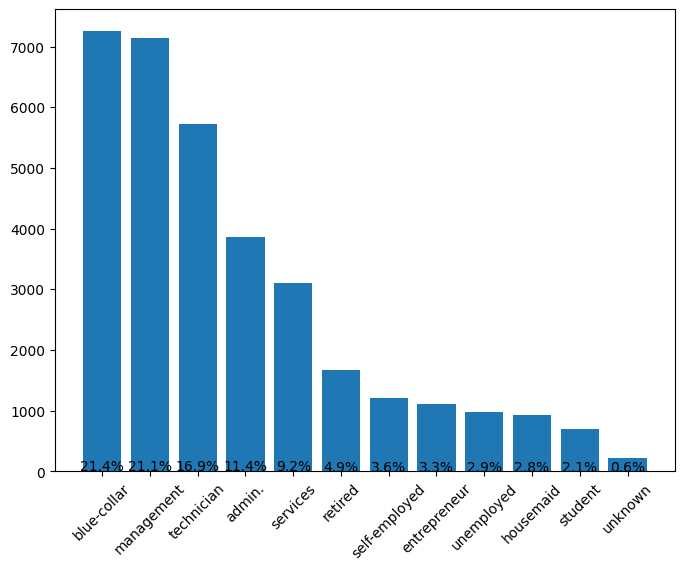

In [14]:
plt.figure(figsize=(8,6))
plt.bar(job.index,job['Count'])
for i,j in enumerate(job['Percentage']):
    plt.text(i,j+1,f'{j:.1f}%',ha='center')
plt.xticks(rotation=45)
plt.show()

##### Observation: 
* It is observed that 21.4% of clients have Blue-collar jobs (Blue collar jobs typically refer to occupations that involve manual labor and often require specialized training or skills Eg. Welder, Plumber, etc) 
* Management Jobs are next to Blue-collar jobs with 21.1% of clients


#### (4)Marital Status
    The marital variable is a categorical variable that represents the marital status of clients. It can take on one of three values: "married", "divorced", or "single".
    Note: The "divorced" category includes both individuals who are divorced and those who are widowed.

In [15]:
a = df_train['marital'].value_counts()
b = df_train['marital'].value_counts()/df_train.shape[0]*100
marital = pd.concat([a,b],axis=1,keys=['Count','Percentage'])
marital

,Count,Percentage
married,20399,60.159844
single,9601,28.314852
divorced,3908,11.525304


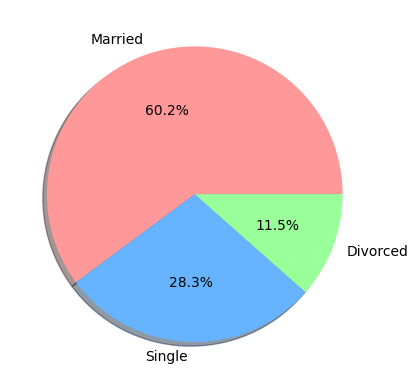

In [16]:
keys = ['Married','Single','Divorced']
colors = ['#ff9999','#66b3ff','#99ff99']

plt.pie(df_train['marital'].value_counts(), labels=keys, colors=colors, autopct='%.1f%%',shadow=True)
plt.show()

##### Observation: 
* It is observed that 60.2% of the clients are Married, 28.3% of the clients are Single, and 11.5% of the clients are Divorced(Divorced or Widowed)

#### (5)Education
    Education" is a categorical variable that can take on four possible values:

    * "unknown": This category represents missing or unknown information about the person's education level.
    * "secondary": This category refers to education level that typically includes high school or its equivalent.
    * "primary": This category refers to education level that typically includes elementary or grade school.
    * "tertiary": This category refers to education level beyond secondary education, such as college, university, or vocational training.

In [17]:
a = df_train['education'].value_counts()
b = df_test['education'].value_counts()/df_train.shape[0]*100
education = pd.concat([a,b],axis=1,keys=['Count','Percentage'])
education

,Count,Percentage
secondary,17346,17.270261
tertiary,10079,9.502182
primary,5098,5.169871
unknown,1385,1.392002


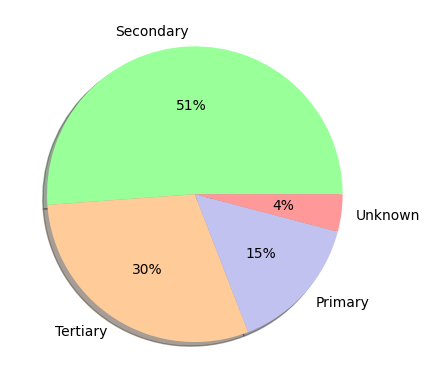

In [18]:
keys = ['Secondary','Tertiary','Primary','Unknown']
colors = ['#99ff99','#ffcc99','#c2c2f0','#ff9999']

plt.pie(df_train['education'].value_counts(), labels=keys, colors=colors, autopct='%1.f%%', shadow=True)
plt.show()

##### Observation: 
* Out of all the clients, 51% have a secondary education level, 30% have a tertiary education level, and 15% have a primary education level.

#### (6)Default
    Default" is a binary variable that indicates whether a person has credit in default. It can take on two possible values:

    * "yes": This value indicates that the person has credit in default, meaning they have failed to repay a loan or credit obligation.
    * "no": This value indicates that the person does not have credit in default, meaning they have successfully repaid their loans or credit obligations on time.
    

    

In [19]:
a = df_train['default'].value_counts()
b = df_train['default'].value_counts()/df_train.shape[0]*100
default = pd.concat([a,b],axis=1,keys=['Count','Percentage'])
default

,Count,Percentage
no,33315,98.25115
yes,593,1.74885


<AxesSubplot: xlabel='default', ylabel='count'>

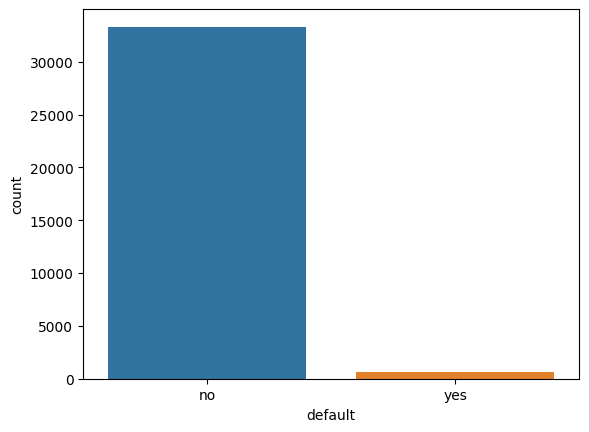

In [20]:
sns.countplot(x='default',data=df_train)

##### Observation: 
* It has been observed that 98.2% of the clients do not have any credit default, while only 1.7% of the clients have a credit default.

#### (7)Balance
    This column represents the average yearly balance in euros for a particular account. It is a numeric column that provides information on the average amount of money that is held in the account over the course of a year.
    

    

In [21]:
#Descriptive Statistics of Balance column
mean_balance = df_train['balance'].mean()
mode_balance = df_train['balance'].mode().iloc[0]
min_balance = df_train['balance'].min()
max_balance = df_train['balance'].max()

# Print the results
print('Mean balance:', mean_balance)
print('Mode balance:', mode_balance)
print('Minimum balance:', min_balance)
print('Maximum balance:', max_balance)


Mean balance: 1370.7131355432346
Mode balance: 0
Minimum balance: -8019
Maximum balance: 102127


Distribution is Right Skewed by 8.675051986060508


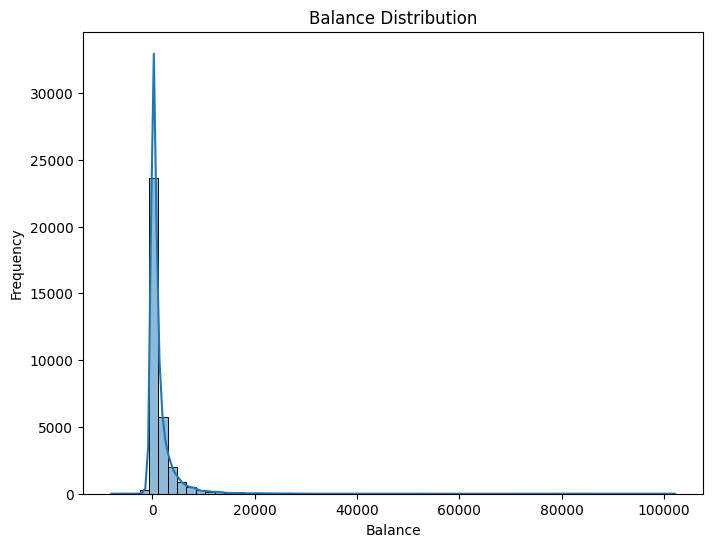

In [22]:
skewness = skew(df_train['balance'])

if skewness > 0:
    print('Distribution is Right Skewed by', skewness)
elif skewness < 0:
    print('Distribution is Left Skewed by', skewness)
else:
    print('Distribution is Symmetric')

#histogram of the Balance column
plt.figure(figsize=(8,6))
sns.histplot(x='balance',data=df_train,bins=60, kde=True)
plt.title('Balance Distribution')
plt.xlabel('Balance')
plt.ylabel('Frequency')
plt.show()


1st Quantile(Q1):  74.0
3st Quantile(Q3):  1430.0
Interquartile range:  74.0
Innerfence:  -1960.0
Outerfence:  3464.0


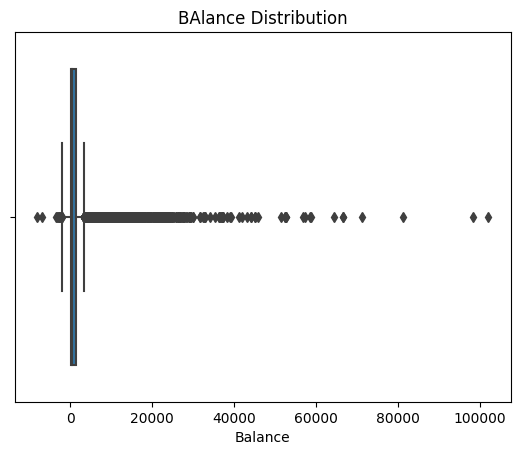

In [23]:
#Quantiles,Innerfence and Outerfence of the Balance column
q1 = df_train['balance'].quantile(0.25)
q3 = df_train['balance'].quantile(0.75)
iqr = q3-q1
innerfence = q1-(1.5*iqr)
outerfence = q3+(1.5*iqr)

print('1st Quantile(Q1): ',q1)
print('3st Quantile(Q3): ',q3)
print('Interquartile range: ',q1)
print('Innerfence: ',innerfence)
print('Outerfence: ',outerfence)

#Boxplot of the age column
sns.boxplot(x='balance',data=df_train)
plt.title('BAlance Distribution')
plt.xlabel('Balance')
plt.show()

##### Observation: 
* The average balance of clients is €1370 (euros).
* Most clients have a balance of 0 (zero).
* The lowest balance of a client is €-8019 (euros).
* The highest balance of clients is €102127 (euros).
* Distribution of Balance Column is Right Skewed by 8.6750


#### (8)Housing
    The "housing" column is a binary categorical variable that indicates whether a client has a housing loan or not. A housing loan is a type of loan that is provided by banks or financial institutions to individuals or families for the purpose of purchasing, constructing or renovating a residential property.
    

    

In [24]:
a = df_train['housing'].value_counts()
b = df_train['housing'].value_counts()/df_train.shape[0]*100
housing = pd.concat([a,b],axis=1,keys=['Count','Percentage'])
housing

,Count,Percentage
yes,18916,55.786245
no,14992,44.213755


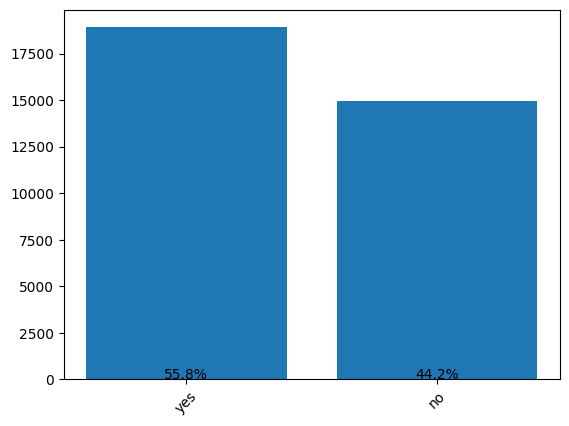

In [25]:
plt.bar(housing.index,housing['Count'])
for i,j in enumerate(housing['Percentage']):
    plt.text(i,j+1,f'{j:.1f}%',ha='center')
plt.xticks(rotation=45)
plt.show()

##### Observation: 
* 55.8% of clients have Housing Loan


#### (9)Loan
    The "loan" column is a binary categorical variable that indicates whether a client has a personal loan or not. A personal loan is a type of loan that is provided by banks or financial institutions to individuals for various purposes, such as debt consolidation, home improvements, education, or emergency expenses. In the context of a dataset, a value of "yes" in the "loan" column would indicate that the client has a personal loan, while a value of "no" would indicate that the client does not have a personal loan.
    

    

In [26]:
a = df_train['loan'].value_counts()
b = df_train['loan'].value_counts()/df_train.shape[0]*100
loan = pd.concat([a,b],axis=1,keys=['Count','Percentage'])
loan

,Count,Percentage
no,28472,83.968385
yes,5436,16.031615


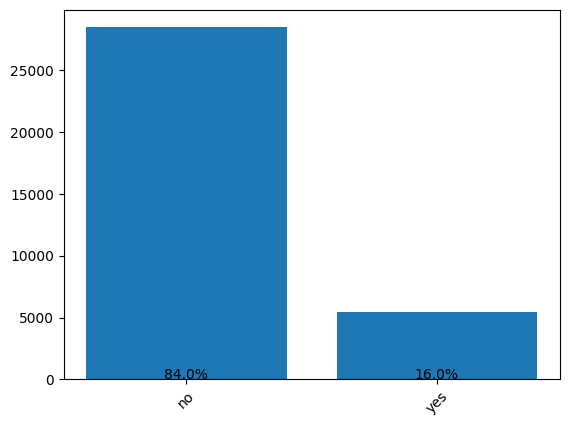

In [27]:
plt.bar(loan.index,loan['Count'])
for i,j in enumerate(loan['Percentage']):
    plt.text(i,j+1,f'{j:.1f}%',ha='center')
plt.xticks(rotation=45)
plt.show()

##### Observation: 
* 84% of clients don't have any personal loan


#### (10)Contact
    The "contact" column is a categorical variable that represents the type of communication method used to contact the client. The possible values in this column are "unknown", "telephone", and "cellular".

In [28]:
a = df_train['contact'].value_counts()
b = df_train['contact'].value_counts()/df_train.shape[0]*100
contact = pd.concat([a,b],axis=1,keys=['Count','Percentage'])
contact

,Count,Percentage
cellular,21994,64.863749
unknown,9750,28.754276
telephone,2164,6.381975


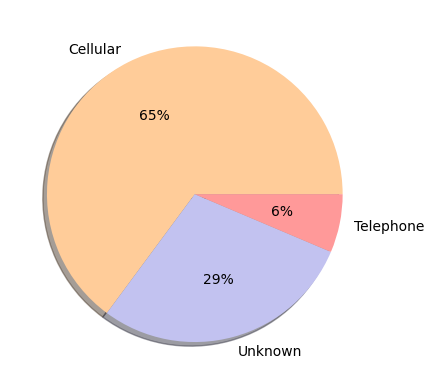

In [29]:
keys = ['Cellular','Unknown','Telephone']
colors = ['#ffcc99','#c2c2f0','#ff9999']

plt.pie(df_train['contact'].value_counts(), labels=keys, colors=colors, autopct='%1.f%%', shadow=True)
plt.show()

##### Observation: 
* 65% of clients have been contacted through Cellular


#### (11)Day
    The "day" column represents the last day of the month on which a client was contacted. It is a numeric variable that can range from 1 to 31, depending on the number of days in the month.

In [30]:
a = df_train['day'].value_counts()
day = pd.DataFrame(a)
day.columns = ['Count']
day

,Count
20,2028
18,1741
21,1500
6,1478
17,1478
5,1423
28,1390
8,1377
7,1375
14,1366


<AxesSubplot: xlabel='day', ylabel='count'>

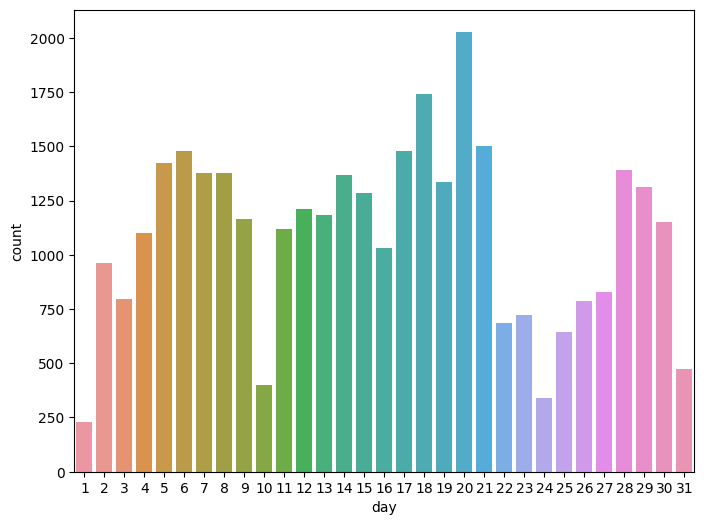

In [31]:
plt.figure(figsize=(8,6))
sns.countplot(x='day',data=df_train)

##### Observation: 
* Many Clients receive their salary at the beginning of the month (5th-8th), which could be a reason for the calls made during this period. Following up after a  two weeks (14th-21st) could also be a reason for the calls made during this period.


#### (12)Month
    The "month" column represents the last month of the year during which a client was contacted. It is a categorical variable that can take on values ranging from "jan" to "dec", representing the months of January through December

In [32]:
a = df_train['month'].value_counts()
b = df_train['month'].value_counts()/df_train.shape[0]*100
month = pd.concat([a,b],axis=1,keys=['Count','Percentage'])
month

,Count,Percentage
may,10308,30.399906
jul,5124,15.111478
aug,4727,13.940663
jun,4004,11.808423
nov,2997,8.838622
apr,2198,6.482246
feb,2025,5.972042
jan,1048,3.090716
oct,525,1.548307
sep,432,1.274036


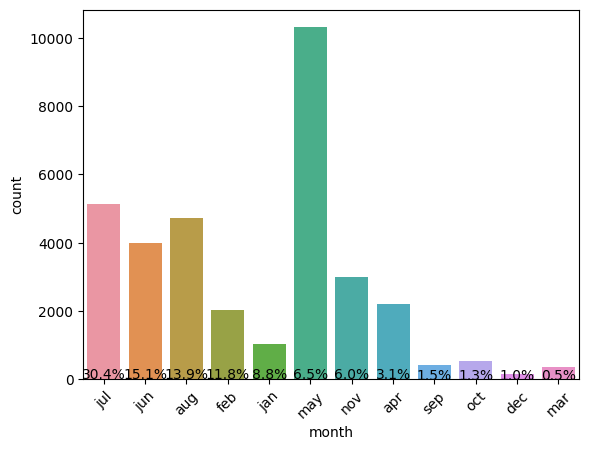

In [33]:
sns.countplot(x='month',data=df_train)
for i,j in enumerate(month['Percentage']):
    plt.text(i,j+1,f'{j:.1f}%',ha='center')
plt.xticks(rotation=45)
plt.show()

##### Observation: 
* It is observed that most of the client were called between the months of May and August

#### (13)Duration
    The "duration" column is a numeric column that represents the length of time in seconds for the last contact made with a client.

In [34]:
#Descriptive Statistics of Duration column
mean_duration = df_train['duration'].mean()
min_duration = df_train['duration'].min()
max_duration = df_train['duration'].max()

# Print the results
print('Average time in Seconds of the last call:', mean_duration)
print('Minimum time in Seconds of the last call:', min_duration)
print('Maximum time in Seconds of the last call:', max_duration)


Average time in Seconds of the last call: 257.8992273209862
Minimum time in Seconds of the last call: 0
Maximum time in Seconds of the last call: 4918


Distribution is Right Skewed by 3.2712903218632934


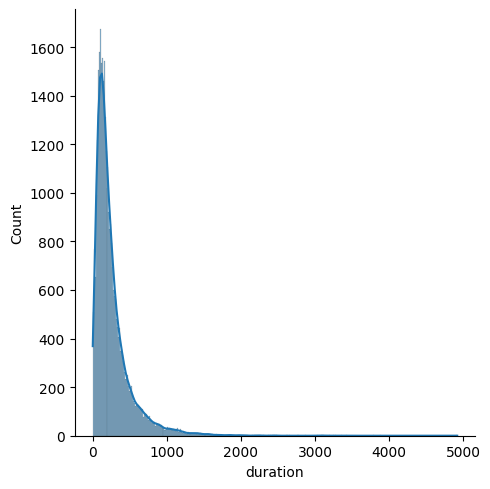

In [35]:
sns.displot(x='duration',data=df_train,kde=True)

skewness = skew(df_train['duration'])

if skewness > 0:
    print('Distribution is Right Skewed by', skewness)
elif skewness < 0:
    print('Distribution is Left Skewed by', skewness)
else:
    print('Distribution is Symmetric')

1st Quantile(Q1):  103.0
3st Quantile(Q3):  318.0
Interquartile range:  103.0
Innerfence:  -219.5
Outerfence:  640.5


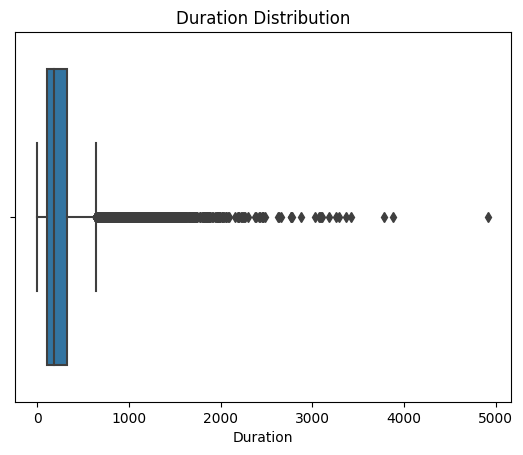

In [36]:
#Quantiles,Innerfence and Outerfence of the Balance column
q1 = df_train['duration'].quantile(0.25)
q3 = df_train['duration'].quantile(0.75)
iqr = q3-q1
innerfence = q1-(1.5*iqr)
outerfence = q3+(1.5*iqr)

print('1st Quantile(Q1): ',q1)
print('3st Quantile(Q3): ',q3)
print('Interquartile range: ',q1)
print('Innerfence: ',innerfence)
print('Outerfence: ',outerfence)

#Boxplot of the age column
sns.boxplot(x='duration',data=df_train)
plt.title('Duration Distribution')
plt.xlabel('Duration')
plt.show()

##### Observation: 
* Average time in Seconds of the last call: 257.9 Seconds
* Minimum time in Seconds of the last call: 0 Seconds
* Maximum time in Seconds of the last call: 4918 Seconds
* Distribution of Duration Column is Right Skewed by 3.271

#### (14)Campaign
    The "campaign" column is a numeric column that represents the number of contacts made during a specific marketing campaign for a particular client. The column includes the last contact made during the campaign, meaning it reflects the total number of times the client was contacted, including the final contact.

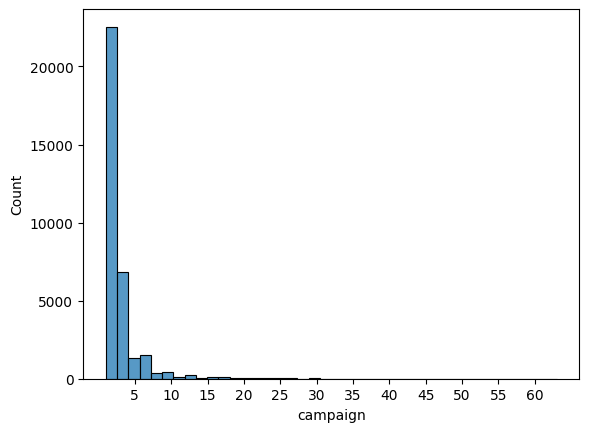

In [37]:
fig, ax = plt.subplots()
sns.histplot(df_train['campaign'],bins=40)
ax.set_xticks([5,10,15,20,25,30,35,40,45,50,55,60])
plt.show()

##### Observation: 
* Most of the Clients are contacted between 3-5 times during a Campaign

#### (15)Pdays
    The "pdays" column in a dataset represents the number of days that passed by after the client was last contacted from a previous campaign. It is a numeric column and takes integer values. A value of -1 indicates that the client was not previously contacted.

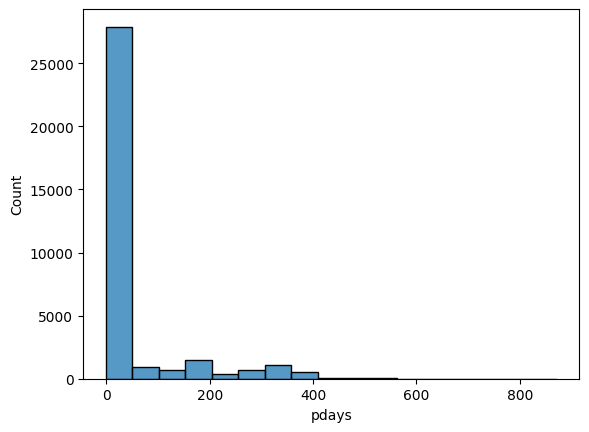

In [38]:
sns.histplot(x='pdays',data=df_train)
plt.show()

##### Observation: 
* Most of the Clients are contacted for the 1st time in this Campaign

#### (16)Previous
    The previous column in a dataset represents the number of contacts that were performed before the current marketing campaign for a given client.

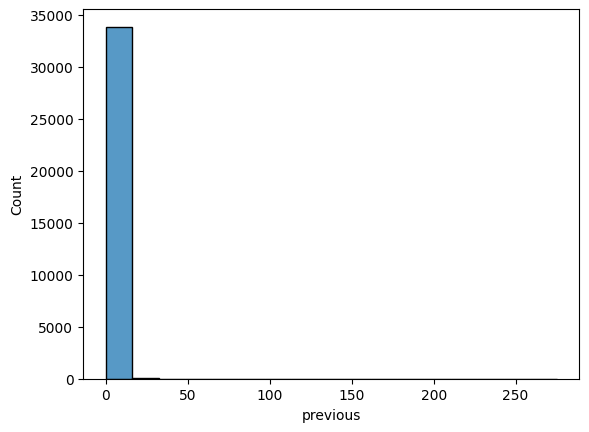

In [39]:
sns.histplot(x='previous',data=df_train)
plt.show()

##### Observation: 
* Most of the Clients are contacted for the 1st time in this Campaign

#### (16)Poutcome
    The poutcome column in a dataset represents the outcome of the previous marketing campaign for a given client. It is a categorical column and can take one of four values:
    * "unknown": the outcome of the previous campaign is unknown
    * "other": the outcome of the previous campaign was something other than success or failure
    * "failure": the previous campaign was a failure
    * "success": the previous campaign was a success

In [40]:
a = df_train['poutcome'].value_counts()
b = df_test['poutcome'].value_counts()/df_train.shape[0]*100
poutcome = pd.concat([a,b],axis=1,keys=['Count','Percentage'])
poutcome

,Count,Percentage
unknown,27710,27.276749
failure,3686,3.583225
other,1373,1.377256
success,1139,1.097086


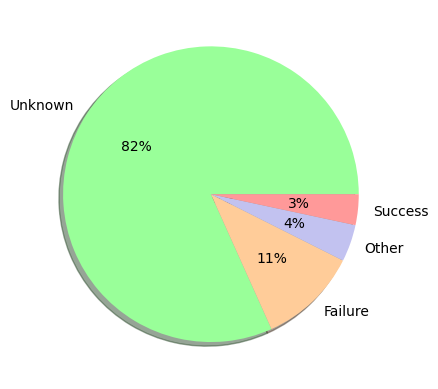

In [41]:
keys = ['Unknown','Failure','Other','Success']
colors = ['#99ff99','#ffcc99','#c2c2f0','#ff9999']

plt.pie(df_train['poutcome'].value_counts(), labels=keys, colors=colors, autopct='%1.f%%', shadow=True)
plt.show()

##### Observation: 
* Most of the Previous campaign outcomes are unknown

## Bivariate and Multivariate Analysis

In [42]:
# Separating numerical and categorical features
numerical_features = df_train.select_dtypes(include=['int64', 'float64'])
categorical_features = df_train.select_dtypes(include=['object', 'category'])

#### (1)Target Variable with Categorical Features

In [43]:
#Droping the target variable
x = categorical_features.drop(columns='y',axis=1)

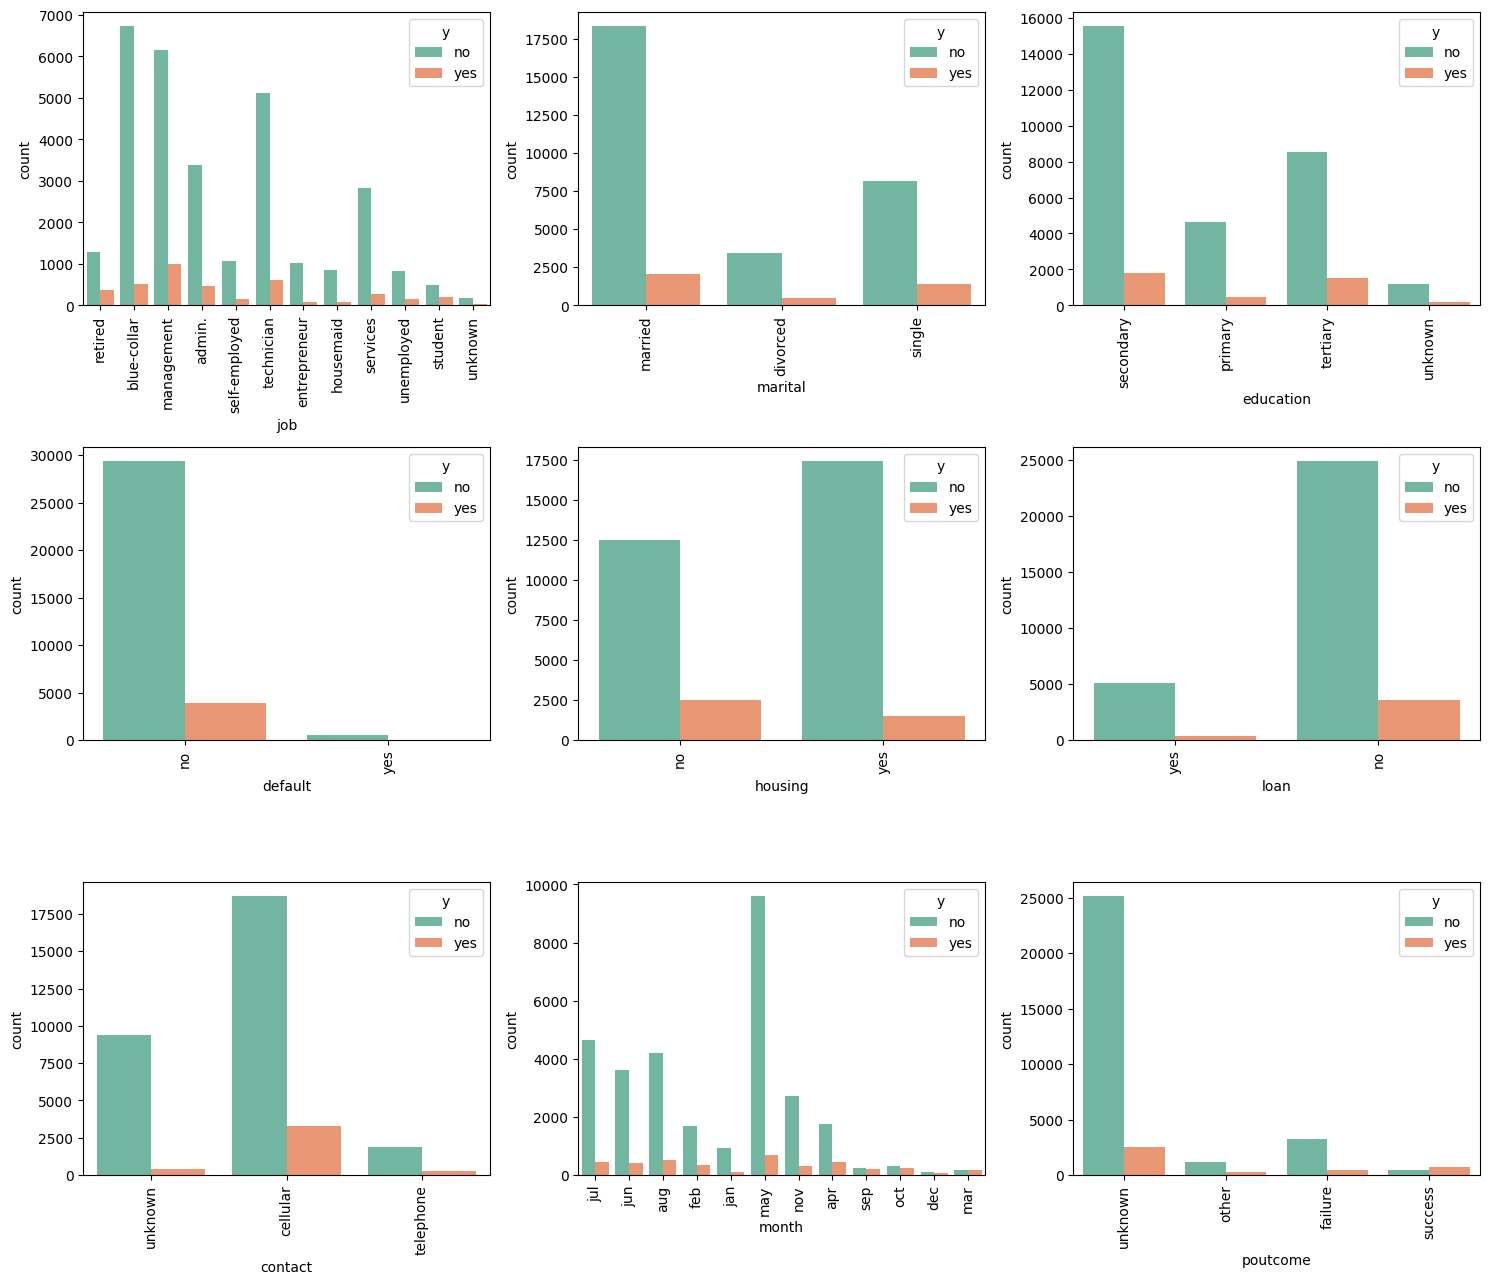

In [44]:
z = 1
plt.figure(figsize = (15,25))
for i in x.columns:
    plt.subplot(6,3,z)
    sns.countplot(x=i,hue='y',data=df_train,palette='Set2')
    z+=1
    plt.xticks(rotation =90)
    plt.tight_layout()

In [45]:
from colorama import Fore
for i in categorical_features.columns:
    a = df_train[df_train['y']=='yes'][i].value_counts()/(df_train['y']=='yes').value_counts()[True]*100
    b = df_train[df_train['y']=='no'][i].value_counts()/(df_train['y']=='yes').value_counts()[False]*100
    print(Fore.LIGHTCYAN_EX,'_'*80)
    print(Fore.LIGHTMAGENTA_EX,i)
    print('-' * len(i),'\n')
    print(Fore.GREEN,'Percentage of Client based on',i,'feature Subscribed to Term Deposit','\n',a,'\n')
    print(Fore.RED,'Percentage of Client based on',i,'feature Not Subscribed to Term Deposit','\n',b)

 ________________________________________________________________________________
 job
--- 

 Percentage of Client based on job feature Subscribed to Term Deposit 
 management       25.056718
technician       15.502899
blue-collar      13.284598
admin.           11.872952
retired           9.629443
services          6.957399
student           5.092009
unemployed        3.806403
self-employed     3.705571
entrepreneur      2.243509
housemaid         2.117469
unknown           0.731031
Name: job, dtype: float64 

 Percentage of Client based on job feature Not Subscribed to Term Deposit 
 blue-collar      22.454160
management       20.537056
technician       17.063558
admin.           11.318927
services          9.445242
retired           4.325173
self-employed     3.550316
entrepreneur      3.410040
housemaid         2.838917
unemployed        2.772118
student           1.659931
unknown           0.624562
Name: job, dtype: float64
 ________________________________________________________

##### Observation: 
* Most clients(22.45%) with blue-collar jobs have not subscribed to term deposits. 
* The highest number of clients(25.05%) who have subscribed to term deposits have management jobs. 
* Married clients represent both the highest number of subscribers(52.4%) and the highest number of non-subscribers(61.18%). 
* Clients with secondary education represent both the highest number of subscribers(45.9%) and the highest number of non-subscribers(51.85). 
* Most clients without housing loans(62.64%) and personal loans(90.92) have subscribed to term deposits. 
* Clients contacted in the month of May have the highest number of subscribers(17.67%) and non-subscribers(32.08).

#### (2)Target Variable with Numerical Features

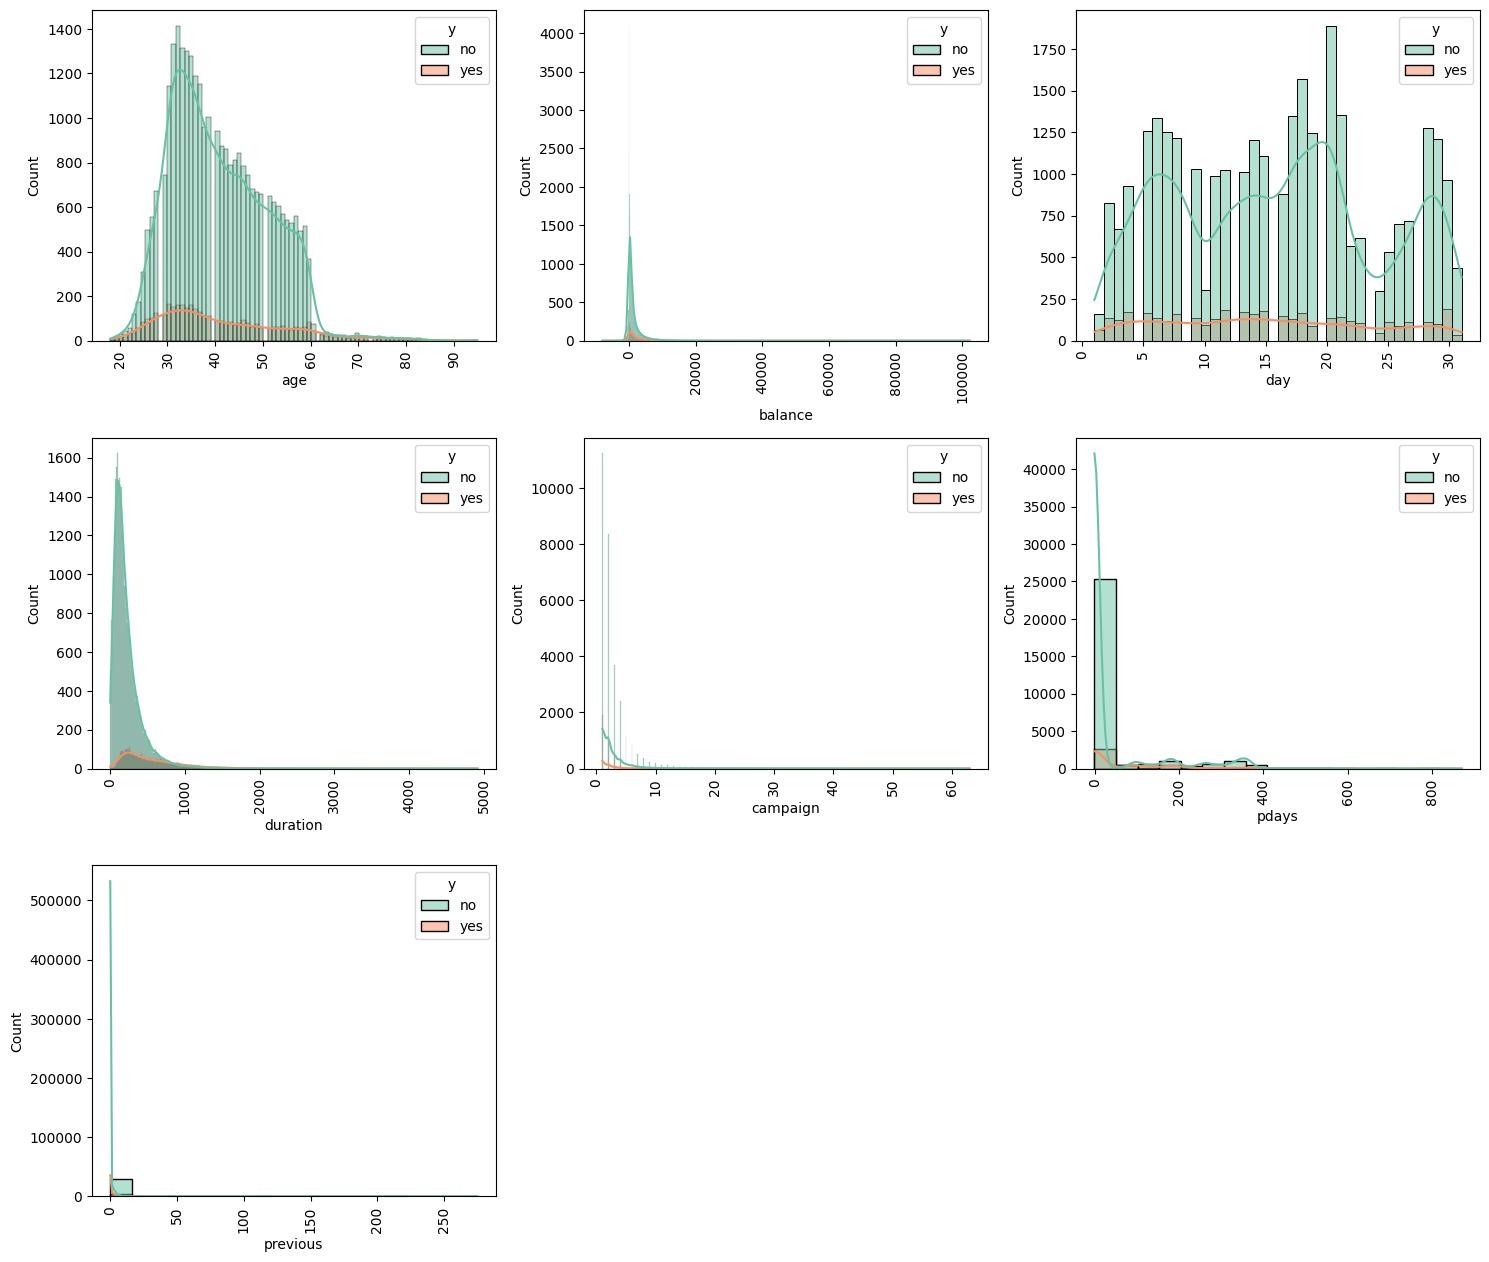

In [46]:
z = 1
plt.figure(figsize = (15,25))
for i in numerical_features.columns:
    plt.subplot(6,3,z)
    sns.histplot(x=i,hue='y',data=df_train,kde=True,palette='Set2')
    z+=1
    plt.xticks(rotation =90)
    plt.tight_layout()

##### Observation: 
* It appears that a significant number of clients between the ages of 30 and 40 years have subscribed to the term deposit product offered by the bank

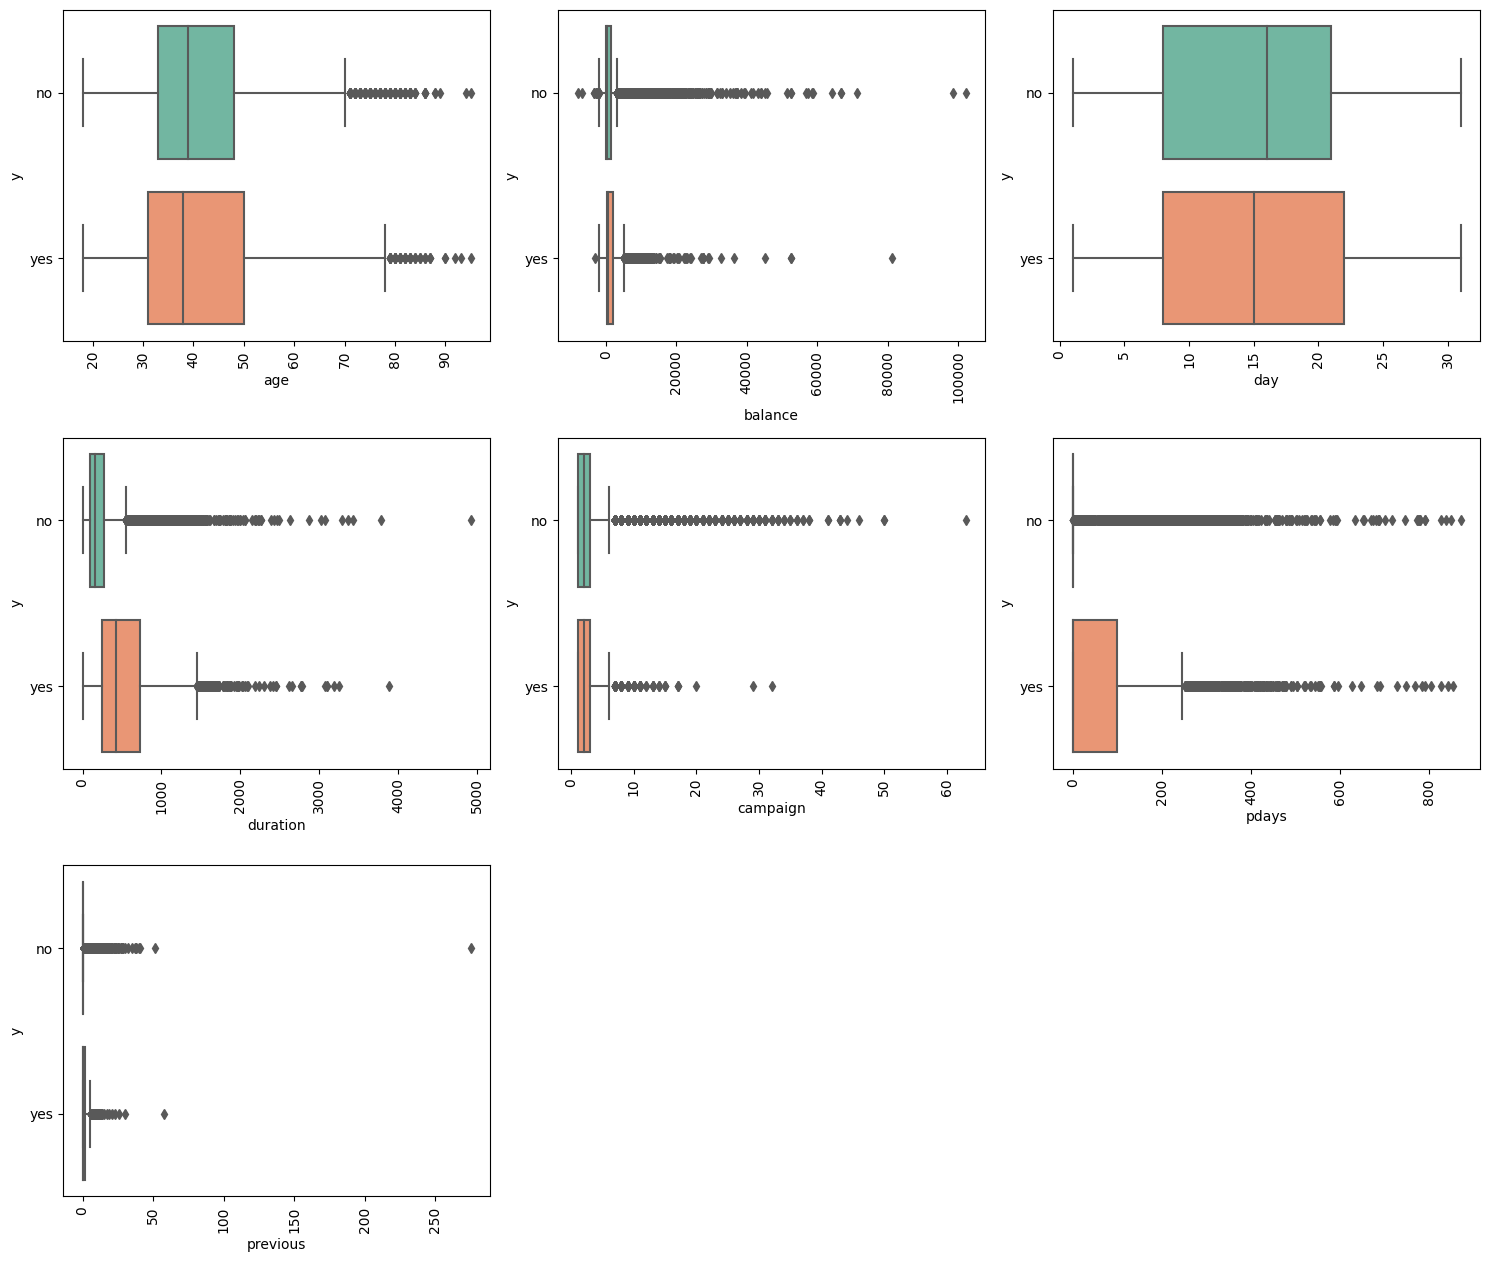

In [47]:
z = 1
plt.figure(figsize = (15,25))
for i in numerical_features.columns:
    plt.subplot(6,3,z)
    sns.boxplot(x=i,y='y',data=df_train,palette='Set2')
    z+=1
    plt.xticks(rotation =90)
    plt.tight_layout()

##### Observation: 
* Average age of clients subscribed is higher than the average age of non-subscribed clients.
* It is observed that clients with longer call duration are more likely to be subscribed.

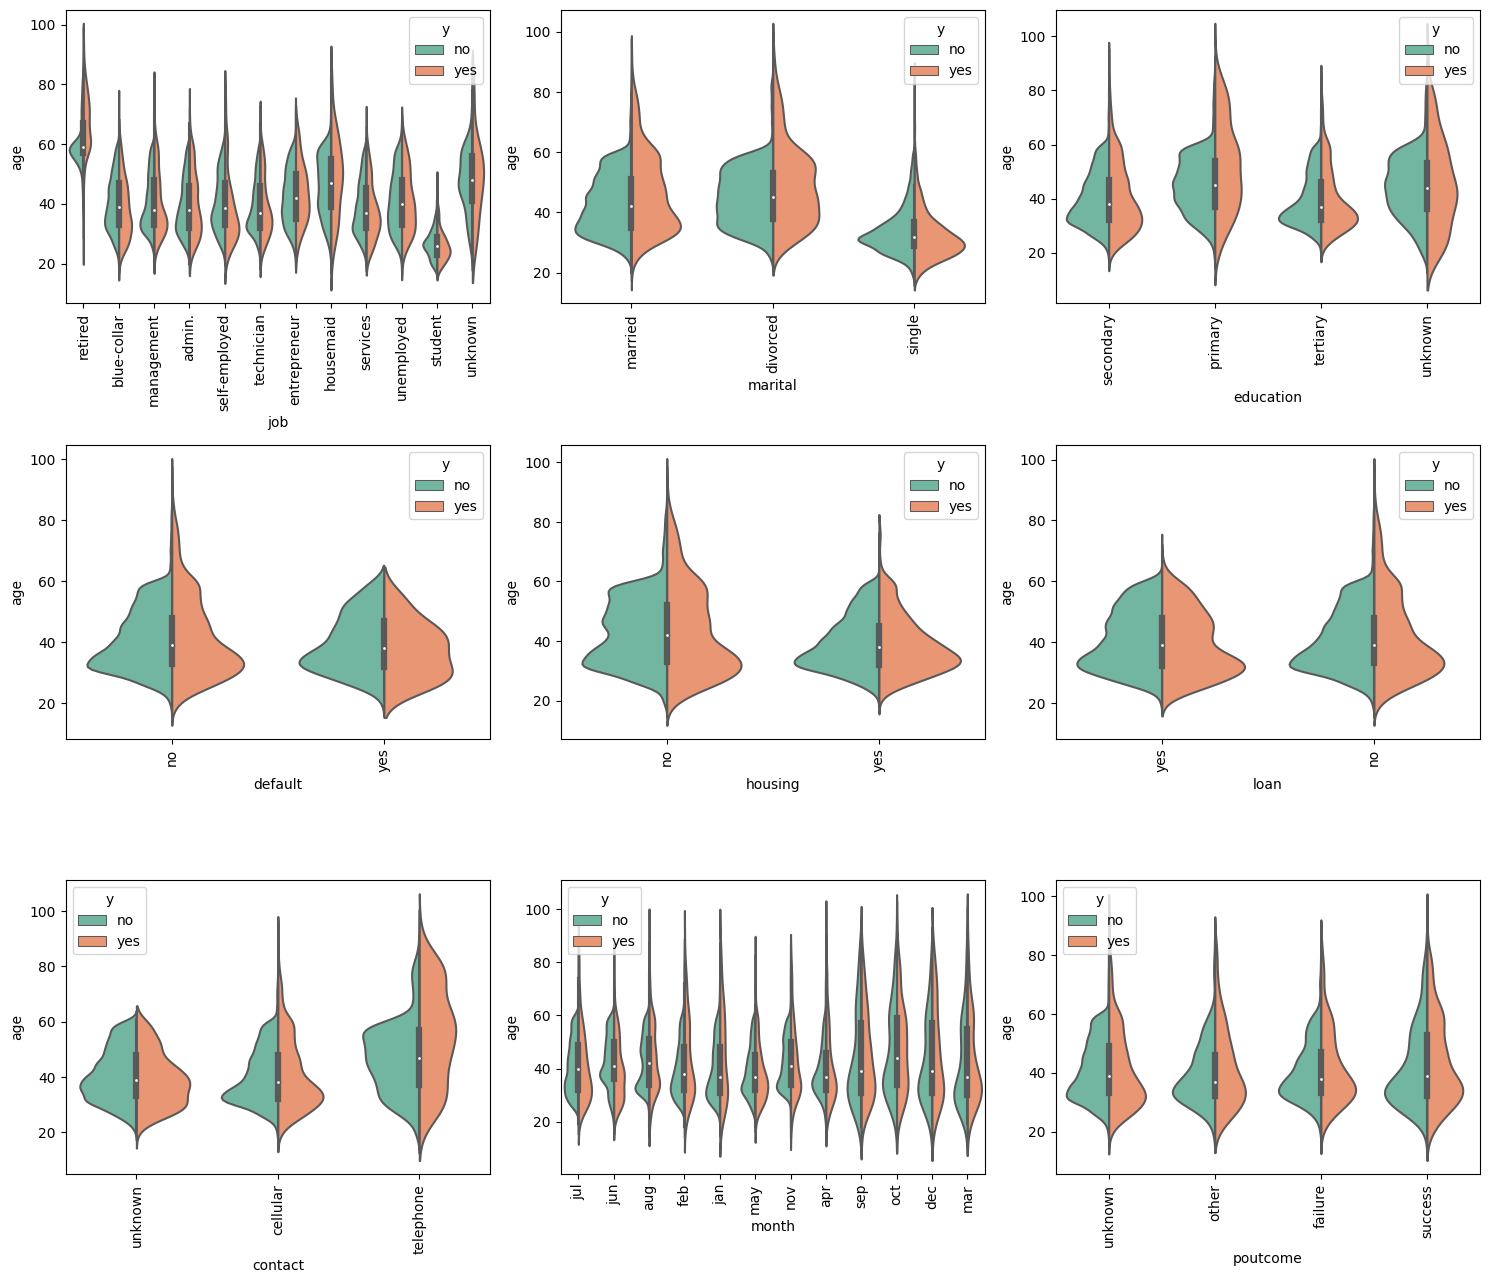

In [48]:
#Droping the target variable
x = categorical_features.drop(columns='y',axis=1)

z = 1
plt.figure(figsize=(15,25))
for i in x.columns:
    plt.subplot(6,3,z)
    sns.violinplot(x=i,y='age',data=df_train,hue='y',split=True,palette='Set2')
    z+=1
    plt.xticks(rotation=90)
    plt.tight_layout()


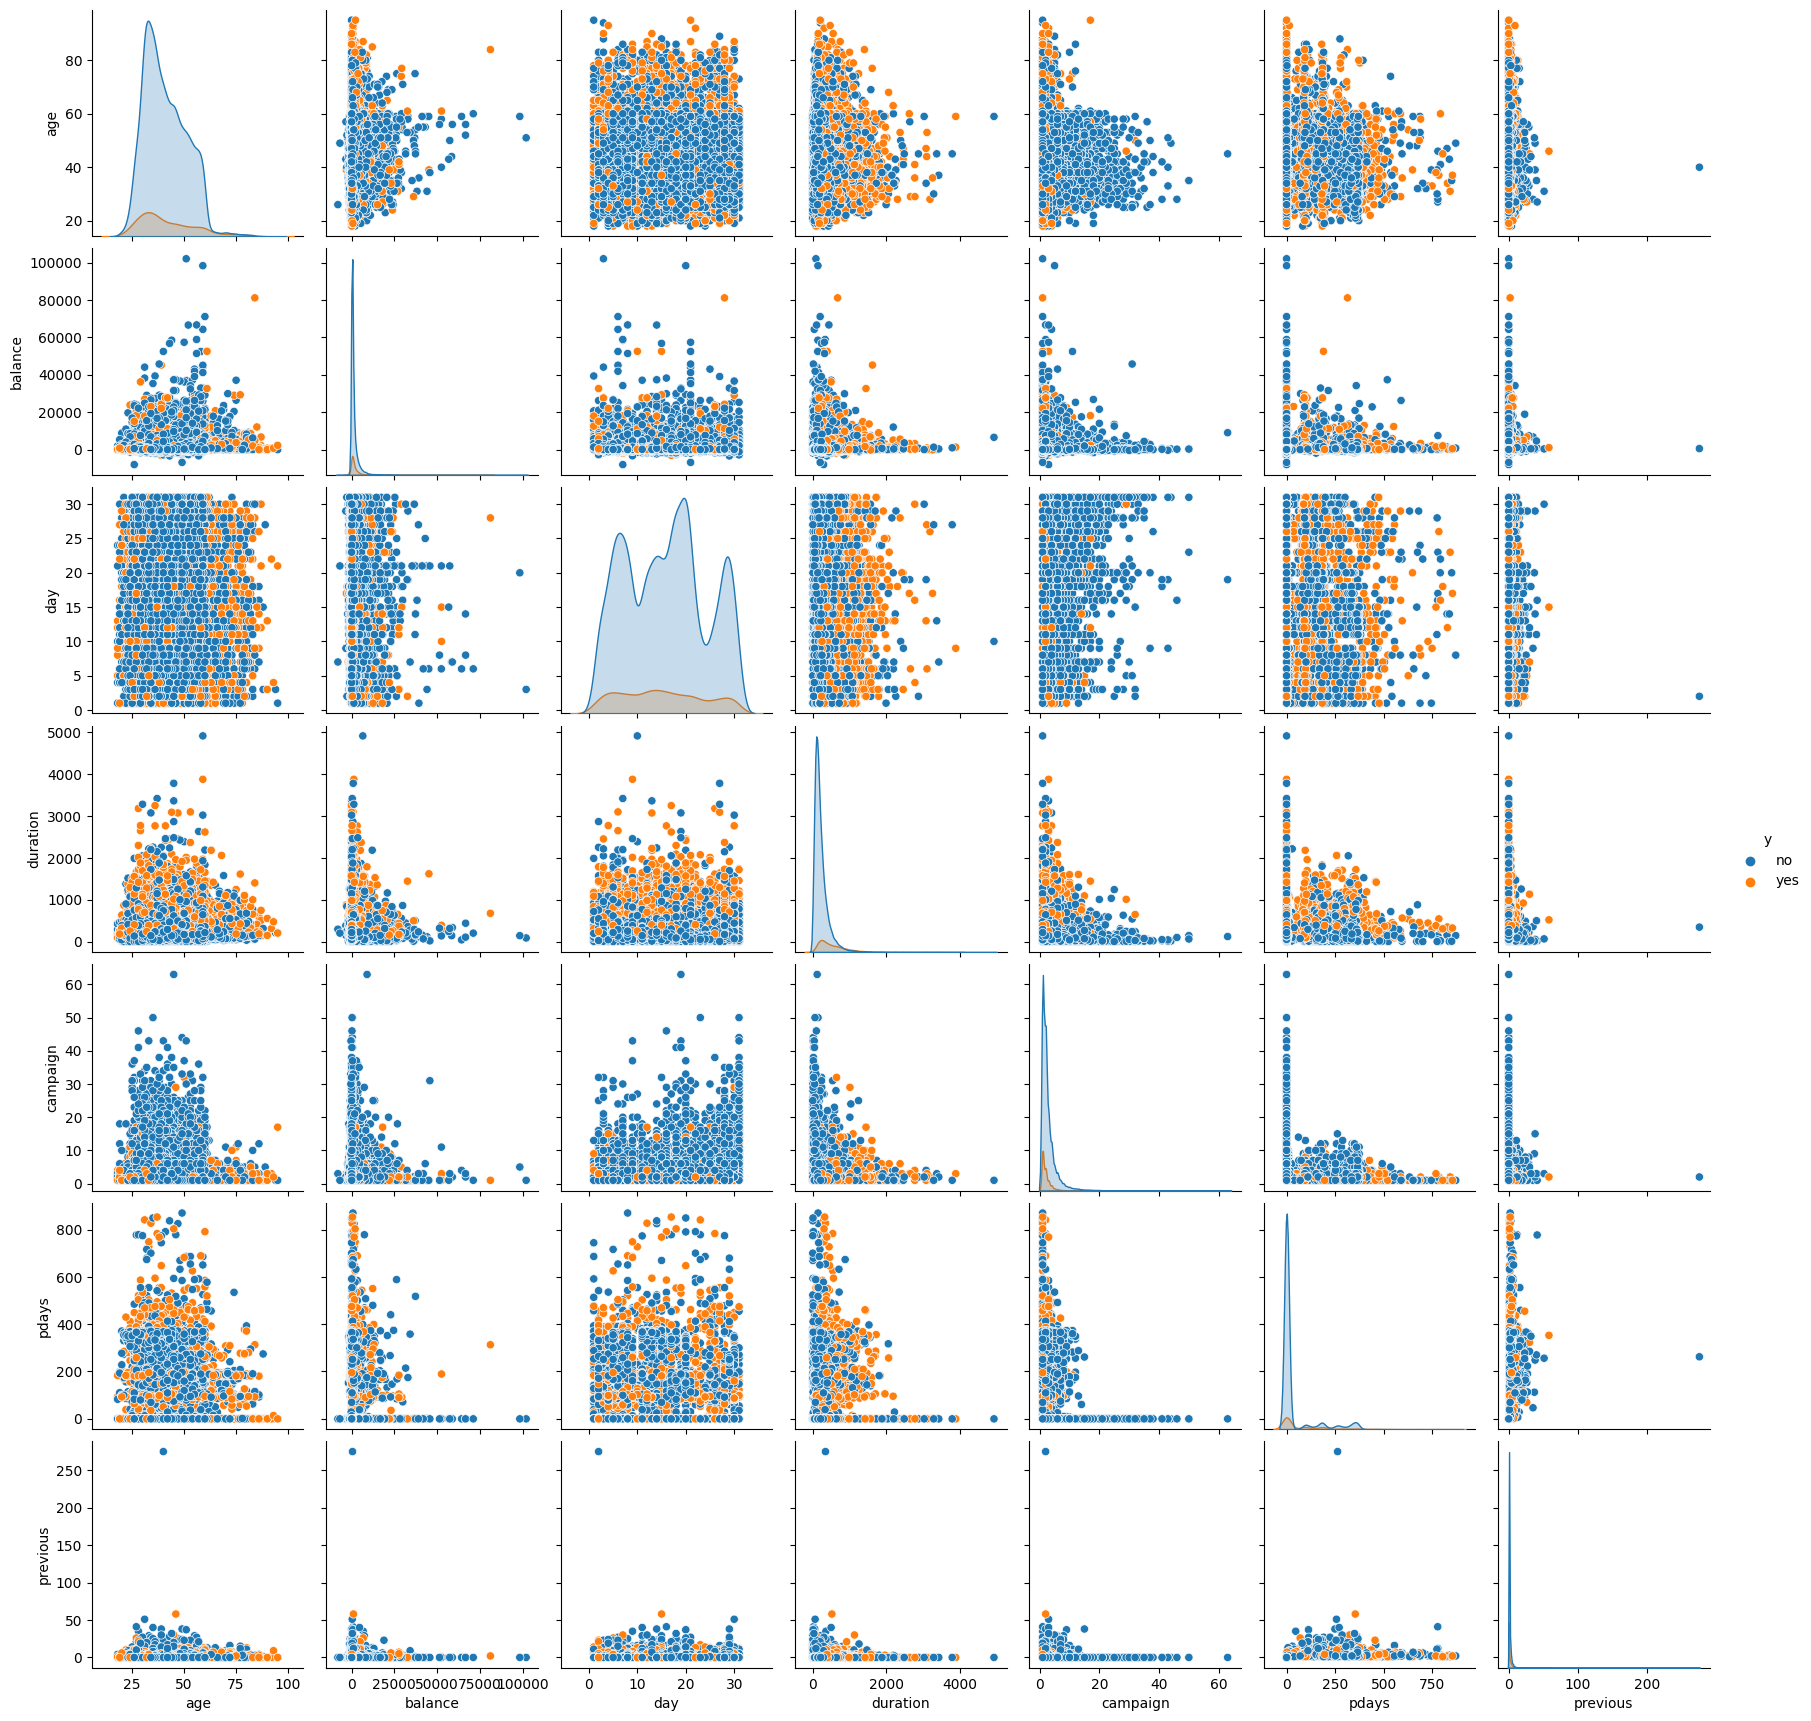

In [49]:
sns.pairplot(df_train,hue='y')
plt.show()

### Checking Multicollinearity

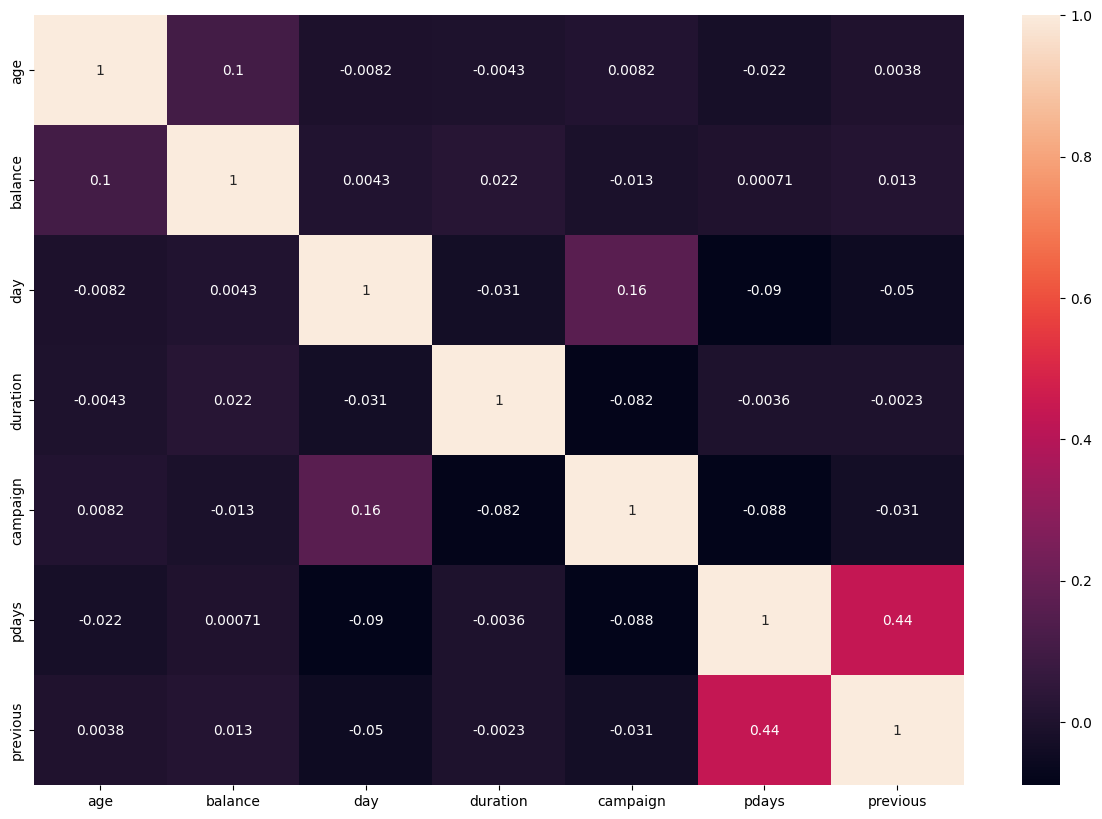

In [50]:
plt.figure(figsize=[15,10])
sns.heatmap(data=df_train.corr(),annot=True)
plt.show()

# Model Building

In [51]:
# Splitting Independent and Target variable

x = df_train.iloc[:,:-1]
y = df_train.iloc[:,-1]

### Feature Encoding

In [52]:
# Target encoding Job column to reduce dimensionality
# Target encoding Month column since month are ordered data
x['job'].replace({'blue-collar':0,'management':1,'technician':2,'admin.':3,'services':4,'retired':5,'self-employed':6,'entrepreneur':7,
                  'unemployed':8,'housemaid':9,'student':10,'unknown':11})

x['month'].replace({'jan':0,'feb':1,'mar':2,'apr':3,'may':4,'jun':5,'jul':6,'aug':7,'sep':8,'oct':9,'nov':10,'dec':11},inplace=True)

# Target encoding Target variable
y.replace({'yes':0,'no':1},inplace=True)


In [53]:
# One-Hot encoding other variables
x_encoded = pd.get_dummies(x,drop_first=True)

### Feature Scaling

In [54]:
scaler = StandardScaler()

x1 = scaler.fit_transform(x_encoded)

### Splitting Training dataset into training and validation sets

In [55]:
X_train, X_val, y_train, y_val = train_test_split(x_encoded, y, test_size=0.3)

### Handling the Imbalance in the dataset

In [79]:
#Combination of Oversampling(SMOTE) and Undersampling(Tomek) techniques
from collections import Counter
counter = Counter(y)
print('Before',counter)

smt = SMOTETomek()

X_sm,y_sm = smt.fit_resample(X_train,y_train)

counter = Counter(y_sm)
print('After',counter)

Before Counter({1: 29941, 0: 3967})
After Counter({1: 20384, 0: 20384})


### Model

#### Logistic Regression

In [57]:
log = LogisticRegression()
log.fit(X_sm,y_sm)
log_train_pred = log.predict(X_sm)
log_val_pred = log.predict(X_val)
print('\x1B[4m' + 'Classification Report:' + '\x1B[0m','\n',classification_report(y_val,log_val_pred))


Classification Report: 
               precision    recall  f1-score   support

           0       0.36      0.70      0.47      1167
           1       0.96      0.84      0.89      9006

    accuracy                           0.82     10173
   macro avg       0.66      0.77      0.68     10173
weighted avg       0.89      0.82      0.84     10173



In [58]:
lr_report = pd.Series({'Model': "Logistic Regression",
                       'Training Accuracy Score': accuracy_score(y_sm,log_train_pred),
                       'Validation Accuracy Score': accuracy_score(y_val,log_val_pred),
                       'Precision Score': precision_score(y_val,log_val_pred),
                       'Recall Score': recall_score(y_val,log_val_pred),
                       'F1 Score' : f1_score(y_val,log_val_pred)})

models_report = pd.DataFrame()
models_report['LR'] = lr_report
models_report

,LR
Model,Logistic Regression
Training Accuracy Score,0.837688
Validation Accuracy Score,0.820898
Precision Score,0.95526
Recall Score,0.836887
F1 Score,0.892164


#### Decision Tree

In [59]:
dt=DecisionTreeClassifier()
dt.fit(X_sm,y_sm)
dt_train_pred = dt.predict(X_sm)
dt_val_pred = dt.predict(X_val)
print('\x1B[4m' + 'Classification Report:' + '\x1B[0m','\n',classification_report(y_val,dt_val_pred))


Classification Report: 
               precision    recall  f1-score   support

           0       0.41      0.53      0.46      1167
           1       0.94      0.90      0.92      9006

    accuracy                           0.86     10173
   macro avg       0.67      0.72      0.69     10173
weighted avg       0.88      0.86      0.87     10173



In [60]:
dt_report = pd.Series({'Model': "Decision Tree",
                       'Training Accuracy Score': accuracy_score(y_sm,dt_train_pred),
                       'Validation Accuracy Score': accuracy_score(y_val,dt_val_pred),
                       'Precision Score': precision_score(y_val,dt_val_pred),
                       'Recall Score': recall_score(y_val,dt_val_pred),
                       'F1 Score' : f1_score(y_val,dt_val_pred)})

models_report['DT'] = dt_report
models_report

,LR,DT
Model,Logistic Regression,Decision Tree
Training Accuracy Score,0.837688,1.0
Validation Accuracy Score,0.820898,0.857368
Precision Score,0.95526,0.936857
Recall Score,0.836887,0.899511
F1 Score,0.892164,0.917804


#### Random Forest

In [61]:
rf = RandomForestClassifier()
rf.fit(X_sm,y_sm)
rf_train_pred = rf.predict(X_sm)
rf_val_pred = rf.predict(X_val)
print('\x1B[4m' + 'Classification Report:' + '\x1B[0m','\n',classification_report(y_val,rf_val_pred))


Classification Report: 
               precision    recall  f1-score   support

           0       0.53      0.52      0.52      1167
           1       0.94      0.94      0.94      9006

    accuracy                           0.89     10173
   macro avg       0.73      0.73      0.73     10173
weighted avg       0.89      0.89      0.89     10173



In [62]:
rf_report = pd.Series({'Model': "Random Forest",
                       'Training Accuracy Score': accuracy_score(y_sm,rf_train_pred),
                       'Validation Accuracy Score': accuracy_score(y_val,rf_val_pred),
                       'Precision Score': precision_score(y_val,rf_val_pred),
                       'Recall Score': recall_score(y_val,rf_val_pred),
                       'F1 Score' : f1_score(y_val,rf_val_pred)})

models_report['RF'] = rf_report
models_report

,LR,DT,RF
Model,Logistic Regression,Decision Tree,Random Forest
Training Accuracy Score,0.837688,1.0,1.0
Validation Accuracy Score,0.820898,0.857368,0.891871
Precision Score,0.95526,0.936857,0.937957
Recall Score,0.836887,0.899511,0.94004
F1 Score,0.892164,0.917804,0.938997


#### Adaboost Classifier

In [63]:
ad = AdaBoostClassifier()
ad.fit(X_sm,y_sm)
ad_train_pred = ad.predict(X_sm)
ad_val_pred = ad.predict(X_val)
print('\x1B[4m' + 'Classification Report:' + '\x1B[0m','\n',classification_report(y_val,ad_val_pred))


Classification Report: 
               precision    recall  f1-score   support

           0       0.45      0.54      0.49      1167
           1       0.94      0.91      0.93      9006

    accuracy                           0.87     10173
   macro avg       0.70      0.73      0.71     10173
weighted avg       0.88      0.87      0.88     10173



In [64]:
ad_report = pd.Series({'Model': "AdaBoost Classifier",
                       'Training Accuracy Score': accuracy_score(y_sm,ad_train_pred),
                       'Validation Accuracy Score': accuracy_score(y_val,ad_val_pred),
                       'Precision Score': precision_score(y_val,ad_val_pred),
                       'Recall Score': recall_score(y_val,ad_val_pred),
                       'F1 Score' : f1_score(y_val,ad_val_pred)})

models_report['AD'] = ad_report
models_report

,LR,DT,RF,AD
Model,Logistic Regression,Decision Tree,Random Forest,AdaBoost Classifier
Training Accuracy Score,0.837688,1.0,1.0,0.918525
Validation Accuracy Score,0.820898,0.857368,0.891871,0.871916
Precision Score,0.95526,0.936857,0.937957,0.939118
Recall Score,0.836887,0.899511,0.94004,0.914612
F1 Score,0.892164,0.917804,0.938997,0.926703


#### Gradient Boosting Classifier

In [65]:
gd = GradientBoostingClassifier(n_estimators=100, max_depth=5)
gd.fit(X_sm,y_sm)
gd_train_pred = gd.predict(X_sm)
gd_val_pred = gd.predict(X_val)
print('\x1B[4m' + 'Classification Report:' + '\x1B[0m','\n',classification_report(y_val,gd_val_pred))


Classification Report: 
               precision    recall  f1-score   support

           0       0.51      0.60      0.56      1167
           1       0.95      0.93      0.94      9006

    accuracy                           0.89     10173
   macro avg       0.73      0.77      0.75     10173
weighted avg       0.90      0.89      0.89     10173



In [66]:
gd_report = pd.Series({'Model': "Gradient Boosting Classifier",
                       'Training Accuracy Score': accuracy_score(y_sm,gd_train_pred),
                       'Validation Accuracy Score': accuracy_score(y_val,gd_val_pred),
                       'Precision Score': precision_score(y_val,gd_val_pred),
                       'Recall Score': recall_score(y_val,gd_val_pred),
                       'F1 Score' : f1_score(y_val,gd_val_pred)})

models_report['GD'] = gd_report
models_report

,LR,DT,RF,AD,GD
Model,Logistic Regression,Decision Tree,Random Forest,AdaBoost Classifier,Gradient Boosting Classifier
Training Accuracy Score,0.837688,1.0,1.0,0.918525,0.944139
Validation Accuracy Score,0.820898,0.857368,0.891871,0.871916,0.889217
Precision Score,0.95526,0.936857,0.937957,0.939118,0.94762
Recall Score,0.836887,0.899511,0.94004,0.914612,0.926049
F1 Score,0.892164,0.917804,0.938997,0.926703,0.93671


#### Naive Bayes Classifier

In [67]:
nb = GaussianNB()
nb.fit(X_sm,y_sm)
nb_train_pred = nb.predict(X_sm)
nb_val_pred = nb.predict(X_val)
print('\x1B[4m' + 'Classification Report:' + '\x1B[0m','\n',classification_report(y_val,nb_val_pred))


Classification Report: 
               precision    recall  f1-score   support

           0       0.26      0.59      0.36      1167
           1       0.94      0.78      0.85      9006

    accuracy                           0.76     10173
   macro avg       0.60      0.68      0.61     10173
weighted avg       0.86      0.76      0.80     10173



In [68]:
nb_report = pd.Series({'Model': "Naive Bayes Classifier",
                       'Training Accuracy Score': accuracy_score(y_sm,nb_train_pred),
                       'Validation Accuracy Score': accuracy_score(y_val,nb_val_pred),
                       'Precision Score': precision_score(y_val,nb_val_pred),
                       'Recall Score': recall_score(y_val,nb_val_pred),
                       'F1 Score' : f1_score(y_val,nb_val_pred)})

models_report['NB'] = nb_report
models_report

,LR,DT,RF,AD,GD,NB
Model,Logistic Regression,Decision Tree,Random Forest,AdaBoost Classifier,Gradient Boosting Classifier,Naive Bayes Classifier
Training Accuracy Score,0.837688,1.0,1.0,0.918525,0.944139,0.839502
Validation Accuracy Score,0.820898,0.857368,0.891871,0.871916,0.889217,0.75956
Precision Score,0.95526,0.936857,0.937957,0.939118,0.94762,0.935822
Recall Score,0.836887,0.899511,0.94004,0.914612,0.926049,0.782034
F1 Score,0.892164,0.917804,0.938997,0.926703,0.93671,0.852045


#### XGBoost Classifier

In [69]:
xgb = XGBClassifier()
xgb.fit(X_sm,y_sm)
xgb_train_pred = xgb.predict(X_sm)
xgb_val_pred = xgb.predict(X_val)
print('\x1B[4m' + 'Classification Report:' + '\x1B[0m','\n',classification_report(y_val,xgb_val_pred))


Classification Report: 
               precision    recall  f1-score   support

           0       0.54      0.58      0.56      1167
           1       0.94      0.94      0.94      9006

    accuracy                           0.89     10173
   macro avg       0.74      0.76      0.75     10173
weighted avg       0.90      0.89      0.90     10173



In [70]:
xgb_report = pd.Series({'Model': "XGBoost Classifier",
                       'Training Accuracy Score': accuracy_score(y_sm,xgb_train_pred),
                       'Validation Accuracy Score': accuracy_score(y_val,xgb_val_pred),
                       'Precision Score': precision_score(y_val,xgb_val_pred),
                       'Recall Score': recall_score(y_val,xgb_val_pred),
                       'F1 Score' : f1_score(y_val,xgb_val_pred)})

models_report['XGB'] = xgb_report
models_report

,LR,DT,RF,AD,GD,NB,XGB
Model,Logistic Regression,Decision Tree,Random Forest,AdaBoost Classifier,Gradient Boosting Classifier,Naive Bayes Classifier,XGBoost Classifier
Training Accuracy Score,0.837688,1.0,1.0,0.918525,0.944139,0.839502,0.971984
Validation Accuracy Score,0.820898,0.857368,0.891871,0.871916,0.889217,0.75956,0.894132
Precision Score,0.95526,0.936857,0.937957,0.939118,0.94762,0.935822,0.9448
Recall Score,0.836887,0.899511,0.94004,0.914612,0.926049,0.782034,0.935043
F1 Score,0.892164,0.917804,0.938997,0.926703,0.93671,0.852045,0.939896


### Choosing Gradient Boosting Classifier as Base Model Since the difference between Training accuracy score and validation accuracy score is within threshold limit of ±5(which means model didnt overfit or underfit) also F1 Score  of Gradient Boosting Classifier is Higher(93.8%).

# Final Model Pipeline

In [71]:
# Splitting Independent and Target variable

x1 = df_train.iloc[:,:-1]
y1 = df_train.iloc[:,-1]

# Target encoding Target variable
y1.replace({'yes':0,'no':1},inplace=True)


In [72]:
X1_train, X1_val, y1_train, y1_val = train_test_split(x1, y1, test_size=0.3)

In [73]:
# Defining the encoding variables
ordinal_variables = ['month']
onehot_variables = ['marital','default','housing','loan','contact','poutcome','education','job']

# Defining ordinal categories
month_order = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']

# Calling the encoder classes
ord_enc = OrdinalEncoder(categories=[month_order])
one_hot_enc = OneHotEncoder(handle_unknown="ignore")

column_transform = make_column_transformer((ord_enc, ordinal_variables),(one_hot_enc, onehot_variables),remainder="passthrough")

In [74]:
pipeline = make_pipeline(
    column_transform,
    StandardScaler(with_mean=False),
    SMOTETomek(),
    GradientBoostingClassifier(
                               )
)

In [75]:
pipeline.fit(X1_train, y1_train)
pred = pipeline.predict(X1_val)

In [76]:
print('Accuracy Score',accuracy_score(y1_val,pred))
print('Precision Score',precision_score(y1_val,pred))
print('Recall Score',recall_score(y1_val,pred))
print('F1 Score',f1_score(y1_val,pred))

Accuracy Score 0.8902978472427012
Precision Score 0.9623263480103602
Recall Score 0.9112597547380156
F1 Score 0.9360971140632156


### Final Model Pipeline has performed well with Accuracy Score of 89.6%, Precision Score of 95.1%, Recall Score of 92.9% and F1 Score of 94%.

In [77]:
test_pred = pipeline.predict(df_test)

In [78]:
# creating a dataframe with predicted values
df_pred = pd.DataFrame({'y_pred': test_pred})

# saving dataframe as CSV file
df_pred.to_csv('predictions.csv', index=False)

### Predicted values of Test data are updated in the submission.csv file